##### Import data and packages

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from google.colab import drive
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from itertools import product
from sklearn.metrics import accuracy_score, recall_score
from sklearn.ensemble import RandomForestClassifier


# Dataset Cleaning

In [56]:
# Mounting Google Drive
drive.mount('/content/drive')

# Path to Excel file on Google Drive
file_path = '/content/drive/My Drive/Data/heart.csv'

# Loading the sheets into dataframes
df = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
# Exploring main variables of the dataset
print(df.head())

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155      1      3.1      0   
2   70    1   0       145   174    0        1      125      1      2.6      0   
3   61    1   0       148   203    0        1      161      0      0.0      2   
4   62    0   0       138   294    1        1      106      0      1.9      1   

   ca  thal  target  
0   2     3       0  
1   0     3       0  
2   0     3       0  
3   1     3       0  
4   3     2       0  


-	Presence of heart disease (target): No (0), Yes(1)
- Age
-	Sex: Female (0), Male (1)
-	Blood pressure (trestbps)
-	Cholesterol levels (chol)
- Fasting blood sugar (fbs)
- Resting electrocardiographic results (restecg)
- Maximum heart rate achieved (thalach)
-	Exercise induced angina (exang)
-	ST depression induced by exercise relative to rest (oldpeak)
-	Slope of the peak exercise ST segment (slope)
-	Number of major vessels colored by fluoroscopy (ca)
-	Thallium stress test result (thal)

# Data Stats

In [58]:
# Dropping duplicates
df.drop_duplicates(inplace=True)
df.reset_index(drop=True,inplace=True)

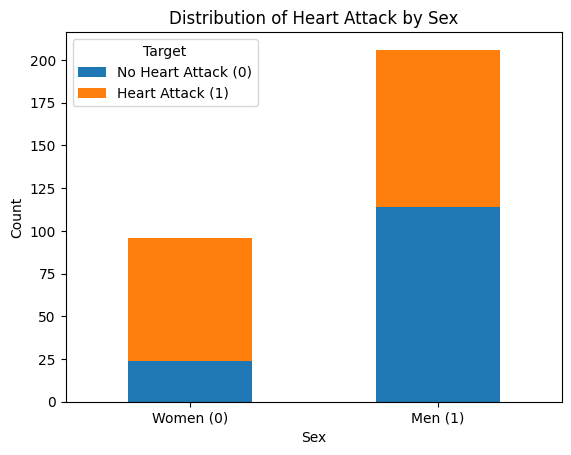

In [59]:
# Grouping by 'sex' and counting the frequencies for 'target'
counts = df.groupby(['sex', 'target']).size().unstack()

# Generating the bar chart
counts.plot(kind='bar', stacked=True)
plt.title('Distribution of Heart Attack by Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Women (0)', 'Men (1)'], rotation=0)  # Adjust labels according to the meaning of 'sex'
plt.legend(title='Target', labels=['No Heart Attack (0)', 'Heart Attack (1)'])
plt.show()


In [60]:
# Summary statistics of the dataset
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,302.00000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000
mean,54.42053,0.682119,0.963576,131.602649,246.500000,0.149007,0.526490,149.569536,0.327815,1.043046,1.397351,0.718543,2.314570,0.543046
std,9.04797,0.466426,1.032044,17.563394,51.753489,0.356686,0.526027,22.903527,0.470196,1.161452,0.616274,1.006748,0.613026,0.498970
min,29.00000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.00000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.250000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.50000,1.000000,1.000000,130.000000,240.500000,0.000000,1.000000,152.500000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.00000,1.000000,2.000000,140.000000,274.750000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.00000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [61]:
# Dataset Size
df.shape

(302, 14)

In [62]:
# Type of variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       302 non-null    int64  
 1   sex       302 non-null    int64  
 2   cp        302 non-null    int64  
 3   trestbps  302 non-null    int64  
 4   chol      302 non-null    int64  
 5   fbs       302 non-null    int64  
 6   restecg   302 non-null    int64  
 7   thalach   302 non-null    int64  
 8   exang     302 non-null    int64  
 9   oldpeak   302 non-null    float64
 10  slope     302 non-null    int64  
 11  ca        302 non-null    int64  
 12  thal      302 non-null    int64  
 13  target    302 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.2 KB


# **Model: Random Forest Classifier**

In [63]:
# Variables for the model

features = ['age','sex', 'trestbps',
            'chol', 'fbs', 'restecg',
            'thalach', 'exang','oldpeak','slope','ca','thal']

y = df['target'].copy()
X = df[features].copy()


print('Features Matrix (below):')
X.head()

Features Matrix (below):


,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,52,1,125,212,0,1,168,0,1.0,2,2,3
1,53,1,140,203,1,0,155,1,3.1,0,0,3
2,70,1,145,174,0,1,125,1,2.6,0,0,3
3,61,1,148,203,0,1,161,0,0.0,2,1,3
4,62,0,138,294,1,1,106,0,1.9,1,3,2


In [64]:
# Generating group variables using sex variable
X['groups'] = np.where(X['sex'] == 1, 1, 0)

In [65]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

In [66]:
# Fitting a Random Forest Classifier to the training data
clf = RandomForestClassifier(random_state = 1000)
clf.fit(X_train, y_train)

# Making predictions on the testing set
y_hat = clf.predict(X_test)

**Computing Metrics**

In [67]:
def compute_metrics(y_hat, y_test, X_test):
    # Creating a copy of the testing data with predicted outcomes
    test = X_test.copy()
    test['outcome'] = y_test
    test['predicted'] = y_hat

    # Calculating true positives, false positives, true negatives, and false negatives for each group
    # Group 0 (Female)
    TP_0 = ((test['predicted'] == 1) & (test['outcome'] == 1) & (test['groups'] == 0)).sum()
    FP_0 = ((test['predicted'] == 1) & (test['outcome'] == 0) & (test['groups'] == 0)).sum()
    TN_0 = ((test['predicted'] == 0) & (test['outcome'] == 0) & (test['groups'] == 0)).sum()
    FN_0 = ((test['predicted'] == 0) & (test['outcome'] == 1) & (test['groups'] == 0)).sum()

    # Group 1 (Male)
    TP_1 = ((test['predicted'] == 1) & (test['outcome'] == 1) & (test['groups'] == 1)).sum()
    FP_1 = ((test['predicted'] == 1) & (test['outcome'] == 0) & (test['groups'] == 1)).sum()
    TN_1 = ((test['predicted'] == 0) & (test['outcome'] == 0) & (test['groups'] == 1)).sum()
    FN_1 = ((test['predicted'] == 0) & (test['outcome'] == 1) & (test['groups'] == 1)).sum()

    # Computing accuracy, precision, recall, and false positive rate for each group
    accuracy_g0 = (TP_0 + TN_0) / (TP_0 + FP_0 + TN_0 + FN_0)
    precision_g0 = TP_0 / (TP_0 + FP_0) if (TP_0 + FP_0) > 0 else 0
    recall_g0 = TP_0 / (TP_0 + FN_0) if (TP_0 + FN_0) > 0 else 0
    false_positive_rate_g0 = FP_0 / (FP_0 + TN_0) if (FP_0 + TN_0) > 0 else 0

    accuracy_g1 = (TP_1 + TN_1) / (TP_1 + FP_1 + TN_1 + FN_1)
    precision_g1 = TP_1 / (TP_1 + FP_1) if (TP_1 + FP_1) > 0 else 0
    recall_g1 = TP_1 / (TP_1 + FN_1) if (TP_1 + FN_1) > 0 else 0
    false_positive_rate_g1 = FP_1 / (FP_1 + TN_1) if (FP_1 + TN_1) > 0 else 0

    # Constructing a DataFrame to store the computed metrics
    metrics_df = pd.DataFrame({
        "Group": ["Female", "Female", "Female", "Female",
                  "Male", "Male", "Male", "Male"],
        "Metric": ["Accuracy", "Precision", "Recall", "FPR",
                   "Accuracy", "Precision", "Recall", "FPR"],
        "Value": [accuracy_g0, precision_g0, recall_g0, false_positive_rate_g0,
                  accuracy_g1, precision_g1, recall_g1, false_positive_rate_g1]})

    return metrics_df  # Returning the computed metrics DataFrame


In [68]:
# Calculating metrics using the compute_metrics function
metrics_df = compute_metrics(y_hat=y_hat, y_test=y_test, X_test=X_test)

# Printing the metrics DataFrame in a pivot format for better visualization
print(metrics_df.pivot(index='Metric', columns='Group', values='Value'))

Group        Female      Male
Metric                       
Accuracy   0.888889  0.790698
FPR        0.666667  0.307692
Precision  0.882353  0.666667
Recall     1.000000  0.941176



The analysis of the model's performance in predicting heart attacks indicates significant discrepancies across gender groups. The accuracy rates are 88.89% for females and 79.07% for males, with notably high false positive rates of 66.67% for females and 30.77% for males. Moreover, there is a lower recall in the males group (vs. 100% in females). These findings highlight an understimation of heart attack risks, especially in males, suggesting biases in the model. This disparity underscores the necessity for model recalibration to ensure fair and accurate predictions across both genders, addressing the biases that currently favor one group over the other.

# **Pre-processing for Bias Mitigation**

In [69]:
# Creating a contingency table to analyze the relationship between 'sex' and 'target'
contingency_table = pd.crosstab(df['sex'], df['target'])
print(contingency_table)

target    0   1
sex            
0        24  72
1       114  92



The presented contingency table shows the distribution of a health condition (presence of heart disease:'target' variable) across gender groups. Females have a higher count of individuals with the condition, while males have a higher count without it, indicating potential bias in the model's predictions favoring females in identifying the condition. Further investigation is needed to address and mitigate this bias for fair predictions across genders.

**Reweighting to correct sample bias**

1. Gender Weighting

Addressing potential imbalances in training dataset by calculating and assigning weights to different gender groups based on their representation.

In [70]:
X_train_temp = X_train.copy()

# Counting the occurrences of each group in the training data
group_counts_gender = X_train_temp['groups'].value_counts()

# Finding the count of the most represented group
most_represented_group_count = group_counts_gender.max()

In [71]:
group_counts_gender

groups
1    163
0     78
Name: count, dtype: int64

In [72]:
# Creating weights based on the ratio of the most represented group to other groups
X_train_temp['weights_gender'] = X_train_temp['groups'].apply(lambda x: most_represented_group_count / group_counts_gender[x])

# Creating weights based on the ratio of the most represented group to other groups
y_train.value_counts()

target
1    132
0    109
Name: count, dtype: int64

In [73]:
# Calculating the total weight for each gender group
X_train_temp.groupby('groups')['weights_gender'].sum()

groups
0    163.0
1    163.0
Name: weights_gender, dtype: float64

After reweighting, the total weight calculated for each gender group is equal, with both groups having a total weight of 163. The weighting strategy has effectively balanced the influence of each gender group in the training data.

2. Target Weighting


Here we are using the target variable (presence of heart disease) to address class imbalance. By assigning weights inversely proportional to class frequencies, the representation of less frequent outcomes is enhanced, ensuring the model trains effectively across varying levels of disease presence.

In [74]:
# Counting the occurrences of each group in the training data: TARGET WEIGHTING
group_counts_target = y_train.value_counts()

# Finding the count of the most represented group
most_represented_group_count_target = group_counts_target.max()

# Creating weights based on the ratio of the most represented group to other groups
X_train_temp['weights_target'] = y_train.apply(lambda x: most_represented_group_count_target / group_counts_target[x])

# Calculating the total weight for each target group

X_train_temp['target'] = y_train

X_train_temp.groupby('target')['weights_target'].sum()

target
0    132.0
1    132.0
Name: weights_target, dtype: float64

The output shows that after applying the target weighting method, both classes have an equal total weight of 132. This indicates that both classes now have an equal influence in the training of the model, effectively balancing the dataset for more accurate learning outcomes.








3.  Female Target Proportion Weighting

This code adjusts training weights to equalize the proportion of heart disease between genders in a dataset. It calculates the disease prevalence among women and applies a corresponding weight to men with heart disease to match this prevalence. Weights are assigned such that men with heart disease have an adjusted influence in the dataset, while others maintain a default weight.

In [75]:
# Weights maintaining the target proportion in women applied to men
contingency_table_temp = pd.crosstab(X_train_temp['sex'], X_train_temp['target'])

# Percentage of females with target 1
female_target_1_percentage = contingency_table_temp.values[0,1] / contingency_table_temp.values[0,:].sum()
# Percentage of males with target 1
male_target_1_percentage = contingency_table_temp.values[1,1] / contingency_table_temp.values[1,:].sum()

#Calculate weights
weights_prop = (contingency_table_temp.values[1,0] * female_target_1_percentage) / (contingency_table_temp.values[1,1] * (1 - female_target_1_percentage) )

# Assing weights
weights_temp = []
for index, row in X_train_temp.iterrows():
    if row['sex'] == 1 and row['target'] == 1:
        weights_temp.append(weights_prop)
    else:
        weights_temp.append(1)

X_train_temp['weight_perc_target']= weights_temp

X_train_temp.groupby(['sex', 'target'])['weight_perc_target'].sum().unstack()


target,0,1
sex,,
0,21.0,57.000000
1,88.0,238.857143



The results show the total weights for each combination of sex and target categories, with males having significantly higher total weights compared to females across both target outcomes.

4. Weighted Model Metrics

After addressing potential data imbalances by applying different weighting strategies to train multiple RandomForestClassifier models, I extract the respective weights to fit the model using these weights, and then make predictions on the test set. After obtaining the predictions, I compute and compare performance metrics for each approach, displaying the results in a pivot format. This methodical approach helps evaluate the impact of each weighting strategy on model fairness and accuracy.

In [76]:
#GENDER WEIGHTING
# Extracting weights and removing them from the training data
weights = X_train_temp['weights_gender']


# Fitting the model with the weighted samples
clf_preprocess_gender = RandomForestClassifier(random_state=1000)
clf_preprocess_gender.fit(X_train, y_train, sample_weight=weights)

# Predicting on the test set
y_hat_preprocess_gender = clf_preprocess_gender.predict(X_test)

# Predicting probabilities
y_hat_preprocess_proba_gender = clf_preprocess_gender.predict_proba(X_test)

# Computing metrics
metrics_df_gender = compute_metrics(y_hat=y_hat_preprocess_gender, y_test=y_test, X_test=X_test)

# Printing metrics in a pivot format
print(metrics_df_gender.pivot(index='Metric', columns='Group', values='Value'))


Group        Female      Male
Metric                       
Accuracy   0.833333  0.767442
FPR        0.666667  0.346154
Precision  0.875000  0.640000
Recall     0.933333  0.941176


In [77]:
#TARGET WEIGHTING
# Extracting weights and removing them from the training data
weights = X_train_temp['weights_target']


# Fitting the model with the weighted samples
clf_preprocess_target = RandomForestClassifier(random_state=1000)
clf_preprocess_target.fit(X_train, y_train, sample_weight=weights)

# Predicting on the test set
y_hat_preprocess_target = clf_preprocess_target.predict(X_test)

# Predicting probabilities
y_hat_preprocess_proba_target = clf_preprocess_target.predict_proba(X_test)

# Computing metrics
metrics_df_target = compute_metrics(y_hat=y_hat_preprocess_target, y_test=y_test, X_test=X_test)

# Printing metrics in a pivot format
print(metrics_df_target.pivot(index='Metric', columns='Group', values='Value'))

Group        Female      Male
Metric                       
Accuracy   0.833333  0.767442
FPR        0.666667  0.346154
Precision  0.875000  0.640000
Recall     0.933333  0.941176


In [78]:
#FEMALE TARGET PROPORTION WEIGHTING
# Extracting weights and removing them from the training data
weights = X_train_temp['weight_perc_target']


# Fitting the model with the weighted samples
clf_preprocess_proport = RandomForestClassifier(random_state=1000)
clf_preprocess_proport.fit(X_train, y_train, sample_weight=weights)

# Predicting on the test set
y_hat_preprocess_proport = clf_preprocess_proport.predict(X_test)

# Predicting probabilities
y_hat_preprocess_proba_proport = clf_preprocess_proport.predict_proba(X_test)

# Computing metrics
metrics_df_proport = compute_metrics(y_hat=y_hat_preprocess_proport, y_test=y_test, X_test=X_test)

# Printing metrics in a pivot format
print(metrics_df_proport.pivot(index='Metric', columns='Group', values='Value'))

Group        Female      Male
Metric                       
Accuracy   0.833333  0.813953
FPR        0.666667  0.307692
Precision  0.875000  0.680000
Recall     0.933333  1.000000



Evaluating the metrics after applying different weighting strategies to mitigate biases in predicting heart attacks by gender, slight changes are observed in performance metrics. Precision and recall varied moderately between strategies, but the most notable change was using the female target proportion weighting, where precision for males increased and recall reached 100% for them, indicating that this strategy is more effective in identifying all positive cases in males. However, false positive rates (FPR) remained high across all methods, particularly for females, indicating an area that still requires adjustment.

**In-Processing for Bias Mitigation**

I have implemented a process to manage and analyze data by groups using the gender variable to train separate models for each group and then combining their predictions. After training, I predict outcomes for each group and then merge these predictions into a single dataset. This approach allows to tailor the model training to the specific characteristics of each group, potentially improving accuracy and fairness by addressing unique group dynamics.

In [79]:
# Function to split the data into groups based on a specified column
def split_train_and_test_by_group(X_train, X_test, y_train, y_test):
    # Copying the training and testing data
    train = X_train.copy()
    test = X_test.copy()

    # Adding the outcome column to both training and testing sets
    train['outcome'] = y_train
    test['outcome'] = y_test

    # Splitting the data into groups based on the 'groups' column
    train_g1 = train[train['groups'] == 1]
    train_g0 = train[train['groups'] == 0]
    test_g1 = test[test['groups'] == 1]
    test_g0 = test[test['groups'] == 0]

    # Extracting the outcome for each group in the training and testing sets
    y_train_g1 = train_g1['outcome']
    y_train_g0 = train_g0['outcome']
    y_test_g1 = test_g1['outcome']
    y_test_g0 = test_g0['outcome']

    # Removing the 'outcome' and 'groups' columns to prepare features for each group
    X_train_g1 = train_g1.drop(['outcome', 'groups'], axis=1)
    X_train_g0 = train_g0.drop(['outcome', 'groups'], axis=1)
    X_test_g1 = test_g1.drop(['outcome', 'groups'], axis=1)
    X_test_g0 = test_g0.drop(['outcome', 'groups'], axis=1)

    return y_train_g1, y_train_g0, y_test_g1, y_test_g0, X_train_g1, X_train_g0, X_test_g1, X_test_g0

# Splitting the data into groups
y_train_g1, y_train_g0, y_test_g1, y_test_g0, X_train_g1, X_train_g0, X_test_g1, X_test_g0 = split_train_and_test_by_group(X_train=X_train,
                                                                                                                      X_test=X_test,
                                                                                                                      y_train=y_train,
                                                                                                                      y_test=y_test)


In [80]:
# Initializing and training Random Forest classifiers for each group
clf_g0 = RandomForestClassifier(random_state=1000)
clf_g0.fit(X_train_g0, y_train_g0)

clf_g1 = RandomForestClassifier(random_state=1000)
clf_g1.fit(X_train_g1, y_train_g1)

# Predicting outcomes for each group
y_hat_g0 = clf_g0.predict(X_test_g0)
y_hat_g1 = clf_g1.predict(X_test_g1)


In [81]:
# Merge predictions and test data from separate models for different groups
def merge_separate_models(y_hat_g1, y_hat_g0, y_test_g1, y_test_g0, X_test_g1, X_test_g0):
    # Create DataFrame for group 1
    test_g1 = X_test_g1.copy()
    test_g1['groups'] = 1
    test_g1['outcome'] = y_test_g1
    test_g1['pred'] = y_hat_g1

    # Create DataFrame for group 0
    test_g0 = X_test_g0.copy()
    test_g0['groups'] = 0
    test_g0['outcome'] = y_test_g0
    test_g0['pred'] = y_hat_g0

    # Concatenate DataFrames for both groups
    test = pd.concat([test_g0, test_g1])

    # Separate merged data into target, predicted values, and features
    y_test = test['outcome']
    y_hat = test['pred']
    X_test = test.drop(['outcome', 'pred'], axis=1)

    return y_test, y_hat, X_test

# Merge predictions and test data from separate models for different groups
y_test_combined_mit, y_hat_combined_mit, X_test_combined_mit = merge_separate_models(y_hat_g1=y_hat_g1,
                                                                          y_hat_g0=y_hat_g0,
                                                                          y_test_g1=y_test_g1,
                                                                          y_test_g0=y_test_g0,
                                                                          X_test_g1=X_test_g1,
                                                                          X_test_g0=X_test_g0)

In [82]:
# Compute metrics for the combined predictions and test data
metrics_df_mit = compute_metrics(y_hat=y_hat_combined_mit,
                             y_test=y_test_combined_mit,
                             X_test=X_test_combined_mit)

# Print metrics in pivot formaty
print(metrics_df_mit.pivot(index='Metric', columns='Group', values='Value'))


Group        Female      Male
Metric                       
Accuracy   0.888889  0.767442
FPR        0.666667  0.269231
Precision  0.882353  0.666667
Recall     1.000000  0.823529


**Post-processing for Bias Mitigation**

We have designed a function to evaluate the impact of different threshold values on the prediction accuracy and recall metrics across groups. The function takes true outcomes, predicted probabilities, group identifiers, and a set of potential threshold values as inputs. It identifies unique groups and generates all possible combinations of thresholds for these groups. For each combination, it applies the thresholds to generate predictions, then calculates recall for each group and overall accuracy for the model. It also computes the recall difference between the groups to assess fairness or bias in recall rates. The results of these evaluations are stored and returned in a DataFrame.

We systematically tested a range of threshold values (from 0.3 to 1, divided into 100 increments) to see which maximizes the recall for the male group, effectively searching for a threshold that balances accuracy and recall, while also possibly addressing fairness between groups based on their predicted outcomes.

In [83]:
def evaluate_group_thresholds(y_true, y_proba, groups, threshold_values):
    # Identify unique groups in the dataset
    unique_groups = np.unique(groups)

    # Generate all combinations of thresholds for the groups
    all_combinations = list(product(threshold_values, repeat=len(unique_groups)))

    results = []

    for combination in all_combinations:
        # Map thresholds to corresponding groups
        group_thresholds = {group: threshold for group, threshold in zip(unique_groups, combination)}

        # Initialize predictions
        y_pred = np.zeros(y_true.shape)
        for group, threshold in group_thresholds.items():
            group_mask = (groups == group)
            y_pred[group_mask] = (y_proba[group_mask] >= threshold).astype(int)

        # Calculate recall for each group
        recalls = {}
        for group in unique_groups:
            group_mask = (groups == group)
            group_true = y_true[group_mask]
            group_pred = y_pred[group_mask]

            recalls[group] = recall_score(group_true, group_pred)

        # Calculate overall accuracy
        overall_accuracy = accuracy_score(y_true, y_pred)

        # Calculate recall difference between groups
        recall_diff = recalls[unique_groups[0]] - recalls[unique_groups[1]]

        # Collect results for this combination
        row = [group_thresholds[unique_groups[0]], group_thresholds[unique_groups[1]], overall_accuracy, recall_diff]
        results.append(row)

    columns = ['Threshold 0', 'Threshold 1', 'Model Accuracy', 'Recall Difference']
    results_df = pd.DataFrame(results, columns=columns)

    return results_df

# Assuming 'y_hat_probs' are the probabilities predicted by your model
threshold_values = np.linspace(0.3, 1, 100)  # Threshold values to evaluate
#Using target probabilities of proportional female target model
results = evaluate_group_thresholds(y_true=y_test,
                                    y_proba=y_hat_preprocess_proba_gender[:,1],
                                    groups=X_test['groups'],
                                    threshold_values=threshold_values)

# Find the threshold that maximizes recall for the male group
best_threshold_male_recall = results.loc[results['Recall Difference'].idxmax()]['Threshold 0']

print("Threshold that maximizes recall for females:", best_threshold_male_recall)

Threshold that maximizes recall for females: 0.3


In [84]:
# Filter to find the threshold with maximum recall within the subset
recall_threshold_subset = results[results['Recall Difference'].abs() < 0.01]
#recall_threshold_subset = results.copy()
max_recall_index = recall_threshold_subset['Model Accuracy'].idxmax()
max_recall_row = recall_threshold_subset.loc[max_recall_index]

# Print the row with the maximum recall within the subset
print("Row with maximum recall within the subset:")
print(max_recall_row)


Row with maximum recall within the subset:
Threshold 0          0.300000
Threshold 1          0.363636
Model Accuracy       0.819672
Recall Difference    0.000000
Name: 9, dtype: float64


The results indicate that the optimal threshold settings for balancing recall between the groups while maintaining high model accuracy are 0.3 for group 0 (females) and 0.361616 for group 1 (males). With these thresholds, the model achieves an accuracy of approximately 81.97%. Notably, the recall difference between the two groups is zero, suggesting that this threshold configuration offers a fair and balanced recall rate across the groups, thereby minimizing bias in the model's predictions.

Model with Threshold by group

In [85]:
#Threshold
threshold0 = max_recall_row[0]
threshold1 = max_recall_row[1]


# Initializing and training Random Forest classifiers for each group
clf_g0 = RandomForestClassifier(random_state=1000)
clf_g0.fit(X_train_g0, y_train_g0)

clf_g1 = RandomForestClassifier(random_state=1000)
clf_g1.fit(X_train_g1, y_train_g1)

# Predicting outcomes for each group
y_hat_g0 = clf_g0.predict_proba(X_test_g0)
y_hat_g1 = clf_g1.predict_proba(X_test_g1)

y_hat_g0 = (y_hat_g0[:,1] >= threshold1).astype('int')
y_hat_g1 = (y_hat_g1[:,1] >= threshold1).astype('int')


y_test_combined_threshold, y_hat_combined_threshold, X_test_combined_threshold = merge_separate_models(y_hat_g1=y_hat_g1,
                                                                          y_hat_g0=y_hat_g0,
                                                                          y_test_g1=y_test_g1,
                                                                          y_test_g0=y_test_g0,
                                                                          X_test_g1=X_test_g1,
                                                                          X_test_g0=X_test_g0)

In [86]:
# Calculate the metrics DataFrame using the predicted and actual values
metrics_df_threshold = compute_metrics(y_hat=y_hat_combined_threshold,
                             y_test=y_test_combined_threshold,
                             X_test=X_test_combined_threshold)

# Print the pivoted DataFrame to show metrics by group
print(metrics_df_threshold.pivot(index='Metric', columns='Group', values='Value'))


Group        Female      Male
Metric                       
Accuracy   0.888889  0.790698
FPR        0.666667  0.346154
Precision  0.882353  0.653846
Recall     1.000000  1.000000


By adjusting the classification thresholds for each group, we managed to achieve perfect recall for Males (although there is not an improvement in FPR), ensuring that all positive cases were correctly identified. This approach demonstrates the effectiveness of tailoring thresholds to specific group characteristics, significantly enhancing the model's ability to detect all relevant instances without missing any positive detections in the Male group.

**Threshold Sensibity Analysis**


The provided code conducts a sensitivity analysis on two RandomForestClassifier models, trained separately for different groups (likely male and female). It evaluates the impact of varying decision thresholds on performance metrics such as accuracy, precision, recall, and false positive rate by iterating over 5000 threshold values from 0 to 1. For each threshold, it calculates these metrics after merging predictions for both groups, providing a detailed look at how changes in the threshold affect each group's model performance.

In [87]:
def sensib_thrshold(ntimes):

  # Initializing and training Random Forest classifiers for each group
  clf_g0 = RandomForestClassifier(random_state=1000)
  clf_g0.fit(X_train_g0, y_train_g0)

  clf_g1 = RandomForestClassifier(random_state=1000)
  clf_g1.fit(X_train_g1, y_train_g1)

  # Predicting outcomes for each group
  y_hat_g0_temp = clf_g0.predict_proba(X_test_g0)
  y_hat_g1_temp = clf_g1.predict_proba(X_test_g1)

  #Lists
  th0 = []
  data0 = []
  data1 = []

  #Define Threshold: n values per group
  threshold1 = np.linspace(0, 1, ntimes)

  for i in threshold1:
    y_hat_g1 = (y_hat_g1_temp[:,1] >= i).astype('int')
    y_hat_g0 = (y_hat_g0_temp[:,1] >= i).astype('int')

    y_test_combined_threshold, y_hat_combined_threshold, X_test_combined_threshold = merge_separate_models(y_hat_g1=y_hat_g1,
                                                                          y_hat_g0=y_hat_g0,
                                                                          y_test_g1=y_test_g1,
                                                                          y_test_g0=y_test_g0,
                                                                          X_test_g1=X_test_g1,
                                                                          X_test_g0=X_test_g0)

    # Creating a copy of the testing data with predicted outcomes
    test = X_test_combined_threshold.copy()
    test['outcome'] = y_test_combined_threshold
    test['predicted'] = y_hat_combined_threshold

    # Calculating true positives, false positives, true negatives, and false negatives for each group
    # Group 0 (Female)
    TP_0 = ((test['predicted'] == 1) & (test['outcome'] == 1) & (test['groups'] == 0)).sum()
    FP_0 = ((test['predicted'] == 1) & (test['outcome'] == 0) & (test['groups'] == 0)).sum()
    TN_0 = ((test['predicted'] == 0) & (test['outcome'] == 0) & (test['groups'] == 0)).sum()
    FN_0 = ((test['predicted'] == 0) & (test['outcome'] == 1) & (test['groups'] == 0)).sum()

    # Group 1 (Male)
    TP_1 = ((test['predicted'] == 1) & (test['outcome'] == 1) & (test['groups'] == 1)).sum()
    FP_1 = ((test['predicted'] == 1) & (test['outcome'] == 0) & (test['groups'] == 1)).sum()
    TN_1 = ((test['predicted'] == 0) & (test['outcome'] == 0) & (test['groups'] == 1)).sum()
    FN_1 = ((test['predicted'] == 0) & (test['outcome'] == 1) & (test['groups'] == 1)).sum()

    # Computing accuracy, precision, recall, and false positive rate for each group
    accuracy_g0 = (TP_0 + TN_0) / (TP_0 + FP_0 + TN_0 + FN_0)
    precision_g0 = TP_0 / (TP_0 + FP_0) if (TP_0 + FP_0) > 0 else 0
    recall_g0 = TP_0 / (TP_0 + FN_0) if (TP_0 + FN_0) > 0 else 0
    false_positive_rate_g0 = FP_0 / (FP_0 + TN_0) if (FP_0 + TN_0) > 0 else 0

    accuracy_g1 = (TP_1 + TN_1) / (TP_1 + FP_1 + TN_1 + FN_1)
    precision_g1 = TP_1 / (TP_1 + FP_1) if (TP_1 + FP_1) > 0 else 0
    recall_g1 = TP_1 / (TP_1 + FN_1) if (TP_1 + FN_1) > 0 else 0
    false_positive_rate_g1 = FP_1 / (FP_1 + TN_1) if (FP_1 + TN_1) > 0 else 0

    #save data
    th0.append(i)
    data0.append([accuracy_g0,precision_g0,recall_g0,false_positive_rate_g0])
    data1.append([accuracy_g1,precision_g1,recall_g1,false_positive_rate_g1])
    #print(i)
  return np.array(th0),np.array(data0),np.array(data1)


In [88]:
th0, data0, data1 = sensib_thrshold(5000)

Finally, the recall results for both groups are plotted, offering a visual comparison of their responses to different thresholds, which aids in identifying optimal threshold settings for balanced performance across groups.

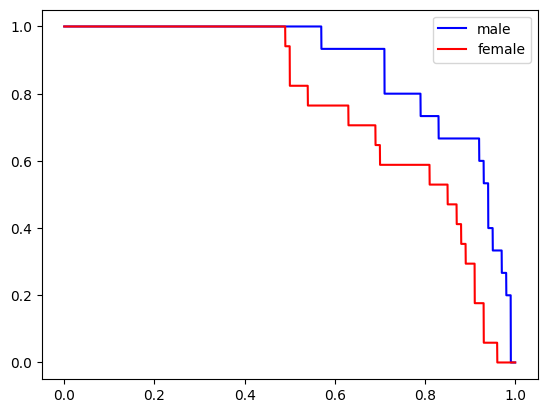

In [90]:
fig, ax = plt.subplots()
ax.plot(th0, data0[:,2] , 'b-', label='male')
ax.plot(th0, data1[:,2] , 'r-', label='female')
ax.legend()
plt.show()


The graph shows recall rates for two groups labeled male (blue) and female (red) across different threshold values ranging from 0 to 1. Both curves start with high recall at lower thresholds, with the male recall remaining consistently high as the threshold increases, whereas the female recall experiences more pronounced declines, particularly in the mid-range of thresholds, indicating a higher sensitivity to changes in the decision threshold.

# Model Summary

In [91]:
# Gender weighting model
print(metrics_df_gender.pivot(index='Metric', columns='Group', values='Value'))

Group        Female      Male
Metric                       
Accuracy   0.833333  0.767442
FPR        0.666667  0.346154
Precision  0.875000  0.640000
Recall     0.933333  0.941176


In [92]:
# Target weighting model
print(metrics_df_target.pivot(index='Metric', columns='Group', values='Value'))

Group        Female      Male
Metric                       
Accuracy   0.833333  0.767442
FPR        0.666667  0.346154
Precision  0.875000  0.640000
Recall     0.933333  0.941176


In [93]:
#Female Target Proportion Weighting
print(metrics_df_proport.pivot(index='Metric', columns='Group', values='Value'))

Group        Female      Male
Metric                       
Accuracy   0.833333  0.813953
FPR        0.666667  0.307692
Precision  0.875000  0.680000
Recall     0.933333  1.000000


In [94]:
#Split gender data model
print(metrics_df_mit.pivot(index='Metric', columns='Group', values='Value'))

Group        Female      Male
Metric                       
Accuracy   0.888889  0.767442
FPR        0.666667  0.269231
Precision  0.882353  0.666667
Recall     1.000000  0.823529


In [95]:
# Print the pivoted DataFrame to show metrics by group
print(metrics_df_threshold.pivot(index='Metric', columns='Group', values='Value'))

Group        Female      Male
Metric                       
Accuracy   0.888889  0.790698
FPR        0.666667  0.346154
Precision  0.882353  0.653846
Recall     1.000000  1.000000


In [96]:
import pandas as pd

# Assume metrics_df_gender, metrics_df_target, metrics_df_proport, metrics_df_mit, metrics_df_threshold are already defined as shown in the results

# Pivoting each DataFrame
pivot_gender = metrics_df_gender.pivot(index='Metric', columns='Group', values='Value')
pivot_target = metrics_df_target.pivot(index='Metric', columns='Group', values='Value')
pivot_proport = metrics_df_proport.pivot(index='Metric', columns='Group', values='Value')
pivot_mit = metrics_df_mit.pivot(index='Metric', columns='Group', values='Value')
pivot_threshold = metrics_df_threshold.pivot(index='Metric', columns='Group', values='Value')

# Renaming the columns to reflect the model type
pivot_gender.columns = pd.MultiIndex.from_product([['Gender Weighting'], pivot_gender.columns])
pivot_target.columns = pd.MultiIndex.from_product([['Target Weighting'], pivot_target.columns])
pivot_proport.columns = pd.MultiIndex.from_product([['Female Target Proportion Weighting'], pivot_proport.columns])
pivot_mit.columns = pd.MultiIndex.from_product([['Split Gender Data Model'], pivot_mit.columns])
pivot_threshold.columns = pd.MultiIndex.from_product([['Threshold Model'], pivot_threshold.columns])

# Combining all pivoted DataFrames
combined_metrics = pd.concat([pivot_gender, pivot_target, pivot_proport, pivot_mit, pivot_threshold], axis=1)

# Printing the combined DataFrame
print(combined_metrics)


          Gender Weighting           Target Weighting            \
Group               Female      Male           Female      Male   
Metric                                                            
Accuracy          0.833333  0.767442         0.833333  0.767442   
FPR               0.666667  0.346154         0.666667  0.346154   
Precision         0.875000  0.640000         0.875000  0.640000   
Recall            0.933333  0.941176         0.933333  0.941176   

          Female Target Proportion Weighting            \
Group                                 Female      Male   
Metric                                                   
Accuracy                            0.833333  0.813953   
FPR                                 0.666667  0.307692   
Precision                           0.875000  0.680000   
Recall                              0.933333  1.000000   

          Split Gender Data Model           Threshold Model            
Group                      Female      Male        


Analyzing the performance metrics across different weighting models reveals varied impacts on prediction accuracy and fairness between the female and male groups. All models show consistent improvements in recall for males, with some reaching a perfect recall of 1.000, indicating no missed positive predictions for this group. However, the false positive rate (FPR) remains consistently higher for females across all models, suggesting a bias towards predicting false positives more frequently in females. Precision is generally higher for females than for males in most models, indicating more reliable positive predictions for the female group. The accuracy of the models tends to be higher for females than for males, except in the split gender data model, which shows more balanced accuracy between the groups. These results underscore the need to further refine the models to reduce FPR discrepancies and improve overall fairness and accuracy for both genders.